# Getting started

In [1]:
#!pip install neuralforecast

### Import libraries

In [2]:
import neuralforecast as nf
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch as t

### Dataset

In [3]:
Y_df, X_df, _ = nf.data.datasets.long_horizon.LongHorizon.load('data', 'ILI')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])
X_df['ds'] = pd.to_datetime(X_df['ds'])
Y_df.head()

,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
2,% WEIGHTED ILI,2002-01-15,-0.342763
3,% WEIGHTED ILI,2002-01-22,-0.199782
4,% WEIGHTED ILI,2002-01-29,-0.218426


### Split train/test sets

In [4]:
output_size = 24
Y_df_test = Y_df.groupby('unique_id').tail(output_size)
Y_df_train = Y_df.drop(Y_df_test.index)

X_df_train = X_df.drop(Y_df_test.index)

### Define WindowsDataset and TimeSeriesLoader

In [5]:
input_size = 5 * output_size

In [6]:
train_mask_df, val_mask_df, _ = nf.experiments.utils.get_mask_dfs(
    Y_df=Y_df_train,
    ds_in_val=7 * output_size,
    ds_in_test=0
)

In [7]:
plot_df = Y_df_train.merge(
    train_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_train'}),
    how='left',
    on=['unique_id', 'ds']
).merge(
    val_mask_df.drop('available_mask', axis=1).rename(columns={'sample_mask': 'sample_mask_val'}),
    how='left',
    on=['unique_id', 'ds']
)

In [8]:
plot_df['y_train'] = np.where(plot_df['sample_mask_train'] == 1, plot_df['y'], np.nan)
plot_df['y_val'] = np.where(plot_df['sample_mask_val'] == 1, plot_df['y'], np.nan)

<AxesSubplot:xlabel='ds'>

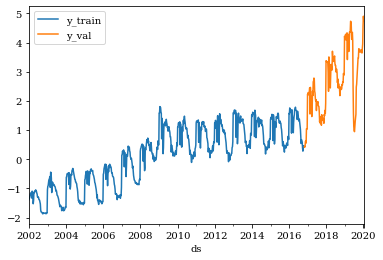

In [9]:
plot_df.query('unique_id == "OT"').set_index('ds')[['y_train', 'y_val']].plot()

In [10]:
train_dataset = nf.data.tsdataset.WindowsDataset(
    Y_df=Y_df_train, 
    X_df=X_df_train,
    f_cols=[f'ex_{i}' for i in range(1, 5)],
    input_size=input_size,
    output_size=output_size,
    mask_df=train_mask_df
)

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)


In [11]:
val_dataset = nf.data.tsdataset.WindowsDataset(
    Y_df=Y_df_train, 
    X_df=X_df_train,
    f_cols=[f'ex_{i}' for i in range(1, 5)],
    input_size=input_size,
    output_size=output_size,
    mask_df=val_mask_df
)

In [12]:
train_loader = nf.data.tsloader.TimeSeriesLoader(
    train_dataset, batch_size=32, 
    n_windows=256,
    shuffle=True
)

In [13]:
val_loader = nf.data.tsloader.TimeSeriesLoader(
    val_dataset, 
    batch_size=1
)

### Define model

In [14]:
model = nf.models.nbeats.nbeats.NBEATS(
    n_time_in=input_size, n_time_out=output_size,
    n_x=4, n_s=0, n_s_hidden=[0], n_x_hidden=[4],
    shared_weights=False, initialization='lecun_normal',
    activation='ReLU', stack_types=3 * ['identity'],
    n_blocks= 3 * [1], n_layers= 9 * [2], n_theta_hidden=3 * [[512, 512]],
    n_harmonics=5, n_polynomials=5,
    batch_normalization=False, dropout_prob_theta=0,
    learning_rate=1e-3, lr_decay=0.5, lr_decay_step_size=5, weight_decay=0,
    loss_train='MAE', loss_hypar=0, loss_valid='MAE',
    frequency='W-TUE', seasonality=52, random_seed=0
)

### Train model with early stopping

In [15]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=1e-4, 
                                            patience=3, verbose=False,mode="min")

trainer = pl.Trainer(max_epochs=20, 
                     max_steps=2_000,
                     gpus=-1 if t.cuda.is_available() else 0,
                     check_val_every_n_epoch=1,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type    | Params
----------------------------------
0 | model | _NBEATS | 2.1 M 
----------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.321     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:133: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/fedex/opt/miniconda3/envs/neuralforecast/lib/python3.7/

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [16]:
Y_df_forecast = model.forecast(Y_df_train, X_df=X_df)
Y_df_forecast.rename(columns={'y': 'y_hat'}, inplace=True)
Y_df_forecast.head()

INFO:root:Train Validation splits

INFO:root:                                      ds           
                                     min        max
unique_id         sample_mask                      
% WEIGHTED ILI    0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
%UNWEIGHTED ILI   0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
AGE 0-4           0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
AGE 5-24          0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
ILITOTAL          0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
NUM. OF PROVIDERS 0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
OT                0           2002-01-01 2020-01-14
                  1           2020-01-21 2020-06-30
INFO:root:
Total data 			6762 time stamps 
Available percentage=100.0, 

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,y_hat
0,% WEIGHTED ILI,2020-01-21,-0.422223
1,% WEIGHTED ILI,2020-01-28,-0.374444
2,% WEIGHTED ILI,2020-02-04,-0.491903
3,% WEIGHTED ILI,2020-02-11,-0.243677
4,% WEIGHTED ILI,2020-02-18,-0.150554


<AxesSubplot:xlabel='ds'>

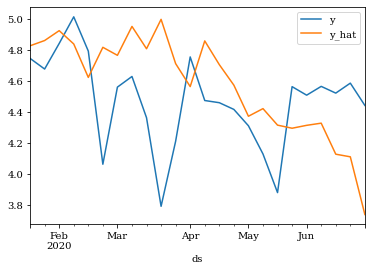

In [17]:
Y_df_plot = Y_df_test.merge(Y_df_forecast, how='left', on=['unique_id', 'ds'])
Y_df_plot.query('unique_id == "OT"').set_index('ds').plot()